# The Data

The data used within this project are provided by the California *Statewide Integrated Traffic Records System (SWITRS)*, which is a database that records the information about every car accident in California which has been reported to the police from 2001 to 2020. 
The data spans from January 1st 2001 till to mid-October 2020.


*data source: https://www.chp.ca.gov/programs-services/services-information/switrs-internet-statewide-integrated-traffic-records-system*

# Importing the needed libraries

In the following the main libraries needed are imported. In particular:

- sqlite3 is a module that provides all the APIs to interact with a SQL database (https://docs.python.org/3/library/sqlite3.html)
- pandas is a module to work with data structres (both heavy or light) presenting them in a dataframe format (https://pandas.pydata.org/docs/getting_started/index.html)
- os, sys are used to navigate the file system 
- matplotlib, seaborn are libraries used to make plots and gain graphical insights from the data (https://matplotlib.org), (https://seaborn.pydata.org)
- numpy is the main python library to manipulate matrices and array (https://numpy.org)
- sqliteschema is a library to extract the schema of a DB in tabular form (https://pypi.org/project/sqliteschema/)
- Utils is a built in class with methods used for the working project

In [28]:
import sqlite3
import pandas as pd 
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sqliteschema

from Utils import *

from mpl_toolkits.basemap import Basemap


colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
blue_line_color = colors[0]
orange_line_color = colors[1]
green_line_color = colors[2]


def setup_plot(title=None, xlabel=None, ylabel=None):
        
    plt.rcParams["figure.figsize"] = (20, 7) 

    # Text Size
    SMALL = 12
    MEDIUM = 16
    LARGE = 20
    HUGE = 28
    plt.rcParams["axes.titlesize"] = HUGE
    plt.rcParams["figure.titlesize"] = HUGE
    plt.rcParams["axes.labelsize"] = LARGE
    plt.rcParams["legend.fontsize"] = LARGE
    plt.rcParams["xtick.labelsize"] = MEDIUM
    plt.rcParams["ytick.labelsize"] = MEDIUM
    plt.rcParams["font.size"] = SMALL

    plt.rcParams["legend.frameon"] = True
    plt.rcParams["legend.framealpha"] = 1
    plt.rcParams["legend.facecolor"] = "white"
    plt.rcParams["legend.edgecolor"] = "black"

    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    return fig, ax

In [29]:
print(os.getcwd())
print(os.listdir(os.getcwd()))
print(os.listdir(os.path.join(os.getcwd(), 'file')))

/Users/christianriccio/Library/CloudStorage/OneDrive-UniversitàdiNapoliFedericoII/PhD/Corsi Dottorato/Data Managment - Mauro Iacono/Exam
['.DS_Store', 'file', '__pycache__', 'Utils.py', '.ipynb_checkpoints', 'FinalExam.ipynb']
['county_ca.geojson', '10m_bathy_to_600m.shp', '.DS_Store', 'switrs.sqlite']


After importing the required modules, to establish the connection between python and the sql database the  .connect() method is used. Such method takes as input a string representing the path to the db.

In [30]:
current_path = os.getcwd()
db = sqlite3.connect(os.path.join(current_path, 'file/switrs.sqlite'))
#db = sqlite3.connect(path)
cur = db.cursor()

As soon as the connection works, an instance of the cursor object is needed in order to perform the queries. The .cursor() object is instanciated and it works as a middleware between python, sql database connection and the query.

### Schema of the DB

The first query invoked allowed me to have a view of all the tables composing the DB

It is composed of the following ones:
- case_ids: used to build the other tables. It tells which of the four original datasets each row came from 
- collisions: contains information about the collision, where it happened, what vehicles were involved
- victims: contains information about the injuries of specific people involved in the collision
- parties: contains information about the groups people involved in the collision including age, sex, and sobriety

In [31]:
tables = cur.execute("SELECT name FROM sqlite_schema WHERE  type ='table' AND name NOT LIKE 'sqlite_%';").fetchall()
print('Tables of the db\n')
for el in tables:
    print(el[0])


Tables of the db

case_ids
collisions
victims
parties


# Star schema of the DB

Before moving forward, let's try to understand better the schema of the DB

In [32]:
extractor = sqliteschema.SQLiteSchemaExtractor(os.path.join(current_path, 'file/switrs.sqlite'))

for verbosity_level in range(2):
    print("--- STAR SCHEMA OF THE DB ---")
    print(extractor.dumps(output_format="markdown", verbosity_level=verbosity_level))


--- STAR SCHEMA OF THE DB ---
# case_ids
|  Field  | Type |
| ------- | ---- |
| case_id | TEXT |
| db_year |      |

# collisions
|              Field              | Type |
| ------------------------------- | ---- |
| case_id                         | TEXT |
| jurisdiction                    | INT  |
| officer_id                      | TEXT |
| reporting_district              | TEXT |
| chp_shift                       | TEXT |
| population                      | TEXT |
| county_city_location            | TEXT |
| county_location                 | TEXT |
| special_condition               | TEXT |
| beat_type                       | TEXT |
| chp_beat_type                   | TEXT |
| city_division_lapd              | TEXT |
| chp_beat_class                  | TEXT |
| beat_number                     | TEXT |
| primary_road                    | TEXT |
| secondary_road                  | TEXT |
| distance                        | REAL |
| direction                       | TEXT |
| interse

### Columns of each table

In [33]:
col_names = {}
for el in tables:
    query = f'SELECT * FROM {el[0]}'
    col_names[el[0]] = [el[0] for el in cur.execute(query).description]

In [34]:
col_names['case_ids']

['case_id', 'db_year']

In [35]:
for el in col_names['collisions']:
    print(el, end = '\t')

case_id	jurisdiction	officer_id	reporting_district	chp_shift	population	county_city_location	county_location	special_condition	beat_type	chp_beat_type	city_division_lapd	chp_beat_class	beat_number	primary_road	secondary_road	distance	direction	intersection	weather_1	weather_2	state_highway_indicator	caltrans_county	caltrans_district	state_route	route_suffix	postmile_prefix	postmile	location_type	ramp_intersection	side_of_highway	tow_away	collision_severity	killed_victims	injured_victims	party_count	primary_collision_factor	pcf_violation_code	pcf_violation_category	pcf_violation	pcf_violation_subsection	hit_and_run	type_of_collision	motor_vehicle_involved_with	pedestrian_action	road_surface	road_condition_1	road_condition_2	lighting	control_device	chp_road_type	pedestrian_collision	bicycle_collision	motorcycle_collision	truck_collision	not_private_property	alcohol_involved	statewide_vehicle_type_at_fault	chp_vehicle_type_at_fault	severe_injury_count	other_visible_injury_count	complaint_

The collisions table contains latitude and longitude of each accident, so being this data geo-refrenced its possible, with Basemap (exstention of matplotlib),  to plot all locations of accidents.

In [36]:
query = 'SELECT latitude, longitude FROM collisions WHERE latitude IS NOT NULL AND longitude IS NOT NULL'
geo_data = Utils.sql_data(cur, query)
geo_data.head()

,latitude,longitude
0,33.86465,-118.28533
1,33.79120,-118.28230
2,33.88450,-118.35260
3,33.83197,-118.20906
4,33.82693,-118.20770


/var/folders/pp/9d_hfgz13nqf65rtspbc9g0r0000gr/T/ipykernel_32321/1100956889.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


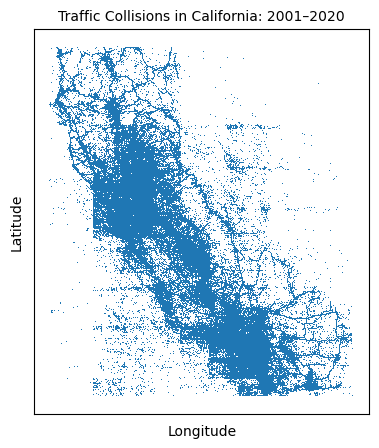

In [37]:
fig = plt.figure(figsize=(30,5))
ax = plt.gca()

basemap = Basemap(
    projection='merc',
    llcrnrlon = -125,   
    llcrnrlat = 32,     
    urcrnrlon = -113.5,   
    urcrnrlat = 42.5,     
)

basemap.plot(
    geo_data['longitude'].values, 
    geo_data['latitude'].values,
    ',',
    latlon=True,
)

ax.set_title("Traffic Collisions in California: 2001–2020", fontsize=10)
ax.set_xlabel("Longitude", fontsize=10)
ax.set_ylabel("Latitude", fontsize=10)

fig.show()

In [38]:
for el in col_names['victims']:
    print(el, end = '\t')

id	case_id	party_number	victim_role	victim_sex	victim_age	victim_degree_of_injury	victim_seating_position	victim_safety_equipment_1	victim_safety_equipment_2	victim_ejected	

In [39]:
for el in col_names['parties']:
    print(el, end = '\t')

id	case_id	party_number	party_type	at_fault	party_sex	party_age	party_sobriety	party_drug_physical	direction_of_travel	party_safety_equipment_1	party_safety_equipment_2	financial_responsibility	hazardous_materials	cellphone_in_use	cellphone_use_type	school_bus_related	oaf_violation_code	oaf_violation_category	oaf_violation_section	oaf_violation_suffix	other_associate_factor_1	other_associate_factor_2	party_number_killed	party_number_injured	movement_preceding_collision	vehicle_year	vehicle_make	statewide_vehicle_type	chp_vehicle_type_towing	chp_vehicle_type_towed	party_race	

# Car crashes

Let's query the crashes that have involved cars in the whole recorded period. 

In [40]:
START_YEAR = 2001
LAST_YEAR = 2020

query = """SELECT Collision_Date FROM collisions AS C
WHERE Collision_Date IS NOT NULL
AND Bicycle_Collision IS NOT 1
AND Motorcycle_Collision IS NOT 1
AND Pedestrian_Collision IS NOT 1
AND Truck_Collision IS NOT 1 
AND collision_date <= '{}-12-31'
""".format(LAST_YEAR)

DATE_COL = "collision_date"
CRASH_COL = "Crashes"

df = pd.read_sql_query(query,db,parse_dates = Utils.date_columns(query))

df["DOY"]     = df[DATE_COL].dt.dayofyear
df["DOW"]     = df[DATE_COL].dt.dayofweek
df["Day"]     = df[DATE_COL].dt.day
df["Week"]    = df[DATE_COL].dt.isocalendar().week
df["Month"]   = df[DATE_COL].dt.month
df["Year"]    = df[DATE_COL].dt.year
df[CRASH_COL] = 1



In [41]:
df.head(5)

,collision_date,DOY,DOW,Day,Week,Month,Year,Crashes
0,2020-03-14,74,5,14,11,3,2020,1
1,2020-07-26,208,6,26,30,7,2020,1
2,2009-02-03,34,1,3,6,2,2009,1
3,2009-02-28,59,5,28,9,2,2009,1
4,2009-02-09,40,0,9,7,2,2009,1


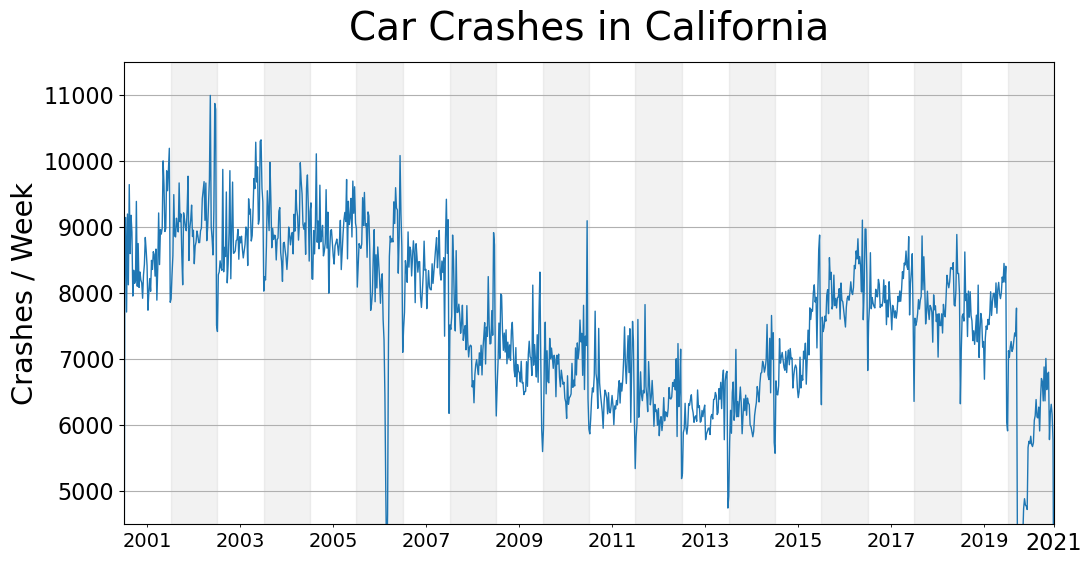

In [42]:
ts = df[[DATE_COL]]
ts.index= ts[DATE_COL]
ax = ts.resample('W-MON').count()[DATE_COL].plot(
    kind="line",
    title='Car Crashes in California',
    figsize=(12,6),
    linewidth=1,
)

ax.grid()
ax.set_xlim((pd.Timestamp("2001-01-01"), pd.Timestamp("2020-12-31")))
ax.set_ylim((4500, 11_500))

plt.title('Car Crashes in California', y=1.03, size=28)
FONTSIZE="xx-large"
plt.xlabel("")
plt.ylabel("Crashes / Week", fontsize=FONTSIZE)

y = ax.get_xlim()
x = (START_YEAR - 0.5, LAST_YEAR + 0.5)

minor_x = np.interp(np.arange(START_YEAR, LAST_YEAR + 2, 2), x, y)
minor_label = np.arange(START_YEAR, LAST_YEAR + 2, 2)

ax.set_xticks(minor_x, minor=True)
ax.set_xticklabels(minor_label, minor=True, size=14)
ax.set_xticks([])

for year in range(START_YEAR + 1, LAST_YEAR + 3, 2):
    ax.axvspan(pd.to_datetime(str(year)), pd.to_datetime(str(year+1)), color="black", alpha=0.05)

From the above plot we can see how the trend of car accidents decresed during the years. 
The first remarckable decrease in car accidents can be observed in the time range 2007-2009, in particular (from google research) in this period USA was interesd by Great Recession that putted many people out of work with a consequent stop of commuting. 
Another small trend in redution in car accidents is clearly linked to the period of the COVID-19 pandemic. 

# Mean Crashes due to festivities

Interesting is the inspection of the mean crashes trend during the national festivities in US. 

In order to accomplish this I've considered the following celebrations: 
- New Year 
- Christmas
- Martin Luther King (MLK) festivity 
- Washington Birthday
- Memorial Day 
- 4th of July
- Labor Day
- Columbus Day
- Veterans Day
- Thanksgiving
- Halloween 
- Valentine's Day
- St. Patrick's Day

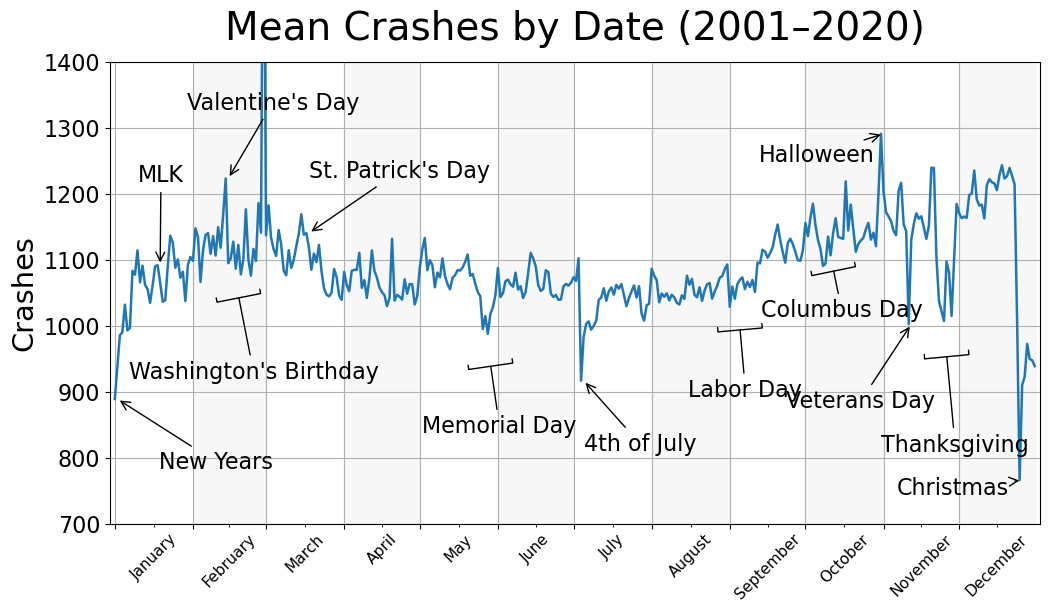

In [43]:

NUMBER_OF_YEARS = (LAST_YEAR - START_YEAR) + 1
LEAP_YEAR_ADJUSTMENT = NUMBER_OF_YEARS/3.

mean_crashes = df.groupby(["Month", "Day"]).count()
mean_crashes[CRASH_COL] /= NUMBER_OF_YEARS 
mean_crashes[CRASH_COL][2][29] = mean_crashes[CRASH_COL][2][29] * LEAP_YEAR_ADJUSTMENT


ax = mean_crashes[CRASH_COL].plot(
    kind="line",
    linewidth=1.8,
    figsize=(12,6),
)

ax.set_ylim([700, 1400])
ax.set_xlim([-2, 367])  
ax.grid()

plt.title('Mean Crashes by Date (2001–2020)', y=1.03, size=28)
FONTSIZE="xx-large"
plt.xlabel('')
plt.ylabel("Crashes", fontsize=FONTSIZE)

(major_x, minor_x) = Utils.month_starts(df,mean_crashes)
labels = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
ax.set_xticks(major_x[:-1])
ax.set_xticklabels([])
ax.set_xticks(minor_x, minor=True)
ax.set_xticklabels(labels, rotation = 45,minor=True, size=11)

for i in range(0, len(major_x)-1, 2):
    start = major_x[i+1]
    end = major_x[i+2]
    ax.axvspan(start, end, color="black", alpha=0.03)

Utils.annotate_year(df, mean_crashes, ax, 1, 1, "New Years", (30, -50))
Utils.annotate_year(df, mean_crashes, ax, 1, 18, "MLK", (-16, 60))
Utils.annotate_year(df, mean_crashes, ax, 2, 18, "Washington's Birthday", (-79, -60), (0, -40), arrowstyle="-[")
Utils.annotate_year(df, mean_crashes, ax, 5, 28, "Memorial Day", (-49, -50), (0, -45), arrowstyle="-[")
Utils.annotate_year(df, mean_crashes, ax, 7, 4, "4th of July", (0, -50))
Utils.annotate_year(df, mean_crashes, ax, 9, 4, "Labor Day", (-37, -50), (0, -65), arrowstyle="-[")
Utils.annotate_year(df, mean_crashes, ax, 10, 11, "Columbus Day", (-52, -35), (0, -20), arrowstyle="-[")
Utils.annotate_year(df, mean_crashes, ax, 11, 11, "Veterans Day", (-90, -60))
Utils.annotate_year(df, mean_crashes, ax, 11, 25, "Thanksgiving", (-47, -70), (0, -50), arrowstyle="-[")
Utils.annotate_year(df, mean_crashes, ax, 12, 25, "Christmas", (-90, -10))

Utils.annotate_year(df, mean_crashes, ax, 10, 31, "Halloween", (-90, -20))
Utils.annotate_year(df, mean_crashes, ax, 2, 14, "Valentine's Day", (-30, 50))
Utils.annotate_year(df, mean_crashes, ax, 3, 17, "St. Patrick's Day", (0, 40))



The average crashes are calculated by by summing the number of crashes on a specific day across the years 2001 to 2020. The sum is then divided by the number of times that specific day appeared in the timespan.
The 2 obvious minima are appreciable with New Year and Christismas celebrations. Instead the maximum is related with Valentine's Day and Halloween ( I guess for this because much more people are outside in the streets).

# Accidents during covid

In California, during the Covid-19 pandemic, the lockdown order has been emanated March 19, 2020. Consequence of this is for sure a decrease in traffic volume. Interesting is the calculation of the traffic rates accidents before and after lockdown order has been emanated. 

With the following query I selected all collisions in the dataset between the start of 2019 and November 30th, 2020, including whether their was a fatality as a result of the collision:

In [55]:
DATE_COL = "collision_date"
CRASH_COL = "crashes"
FATALITY_COL = "fatalities"

query = f"""
    SELECT collision_date
        , 1 as {CRASH_COL}
        , IIF(COLLISION_SEVERITY='fatal', 1, 0) as {FATALITY_COL}
    FROM collisions 
    WHERE {DATE_COL} IS NOT NULL 
    AND {DATE_COL} BETWEEN '2019-01-01' AND '2020-11-30'
"""

df = Utils.sql_data(cur, query)

To be more clear, the query selects three columns from the "collisions" table: "collision_date", "1" (renamed as "{CRASH_COL}"), and a calculated column named "{FATALITY_COL}".

The query selects only those rows where the value of the "{DATE_COL}" column is not null and where the date in this column falls between January 1st of "START_YEAR" and November 30th of "LAST_YEAR".

The "IIF" function is used to calculate the value of the "{FATALITY_COL}" column based on the value of the "COLLISION_SEVERITY" column. If the value of "COLLISION_SEVERITY" is "fatal", then the value of "{FATALITY_COL}" is set to 1, otherwise it is set to 0.

Essentially, this query selects all the collisions that occurred within a specific time range and indicates whether there was at least one fatality or not.

In [56]:
df.head(5)

,collision_date,crashes,fatalities
0,2020-03-14,1,0
1,2020-07-26,1,0
2,2020-10-05,1,0
3,2020-08-06,1,0
4,2020-10-05,1,0


In order to calculate the fatality rate I considered the number of traffic collisions that resulted in a fatality divided by the total number of collisions during the week.

In [58]:
df = df.astype({
    f"{DATE_COL}": "datetime64[ns]",
    CRASH_COL: "int32",
    FATALITY_COL: "int32",
})

ts = df[[DATE_COL, CRASH_COL, FATALITY_COL]]
ts.index= ts[DATE_COL]

ts_series = ts.resample('W-MON').sum(numeric_only = True)

ts_series["fatality_rate"] = ts_series[FATALITY_COL] / ts_series[CRASH_COL]

ts_series.loc[ts_series.index >= '2020-03-19', "is_after_order"] = True
ts_series.loc[ts_series.index < '2020-03-19', "is_after_order"] = False


Text(2020-03-27 00:00:00, 0.005, 'Lockdown')

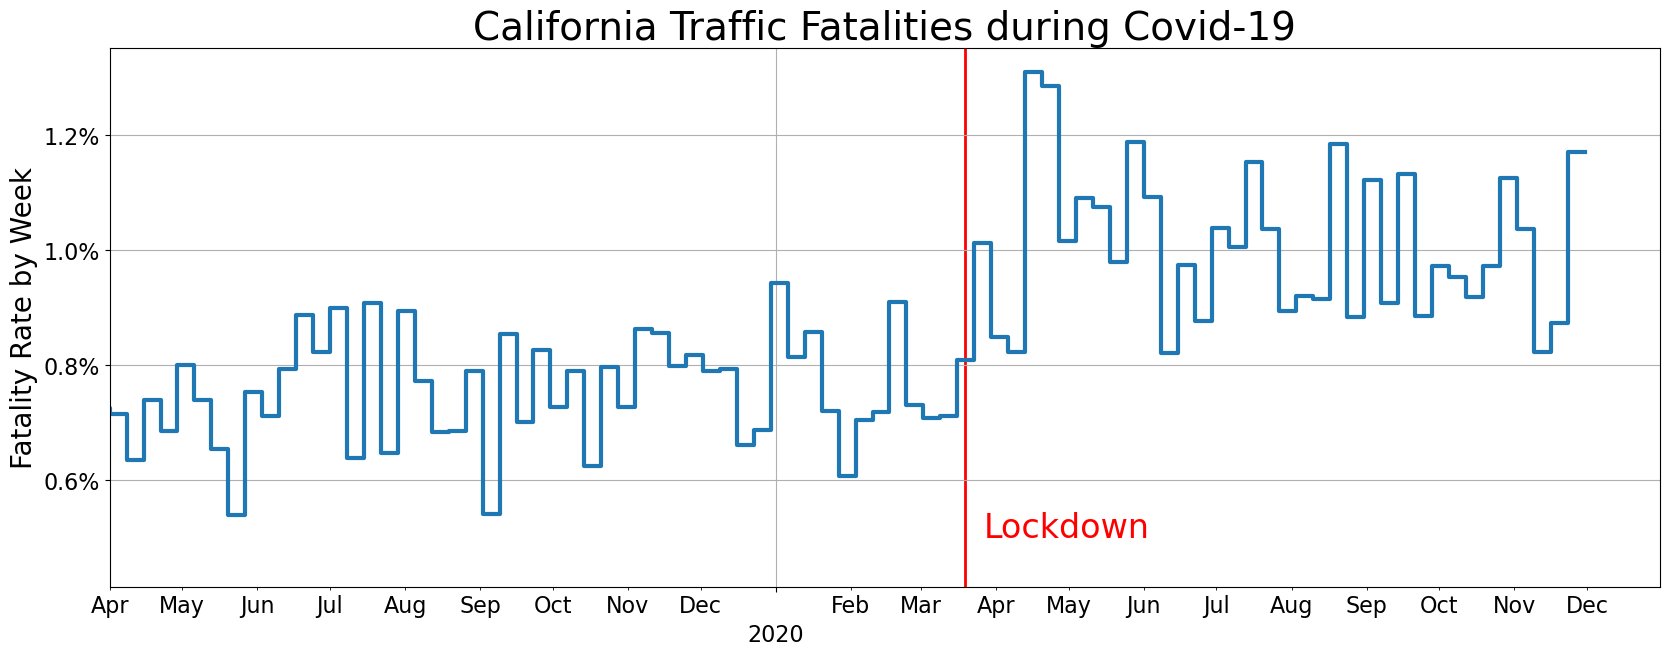

In [73]:

fig, ax = setup_plot(
    title="California Traffic Fatalities during Covid-19",
    ylabel="Fatality Rate by Week",
)

fig.patch.set_facecolor('white')

ax.step(x=ts_series.index, y=ts_series["fatality_rate"], linewidth=3)

ax.grid(which="major")
ax.set_xlim((pd.Timestamp("2019-04-01"), pd.Timestamp("2020-12-31")))

year_locator = mdates.YearLocator()
year_form = mdates.DateFormatter("\n%Y")  
ax.xaxis.set_major_locator(year_locator)
ax.xaxis.set_major_formatter(year_form)

month_locator = mdates.MonthLocator(interval=1)
month_form = mdates.DateFormatter("%b")
ax.xaxis.set_minor_locator(month_locator)
ax.xaxis.set_minor_formatter(month_form)

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))

ax.axvline(x=pd.Timestamp("2020-03-19"), color="red", linewidth=2, zorder=-1, label="Lockdown")
ax.text(x=pd.Timestamp("2020-03-27"), y=0.005, s="Lockdown", color="red", fontsize=24)

Even tough the overall volume of traffic decreased, its surprising how after the the lockdown order the fatality rate has increased: does anyone can guess why?

# Car manifacturer


According to https://www.statista.com the most sold car brand in USA in 2022 are Ford and Toyota (1st and 2nd place in the rank), following with Chevrolet and Honda. 
So, based on that because the main car travelling in the road are them, of course, are the main involved in car accidents. Let's inspect the situation of accident that involved such brands before and during the covid, includig the lockdonw period (March/2020). The time window I am going to consider is 2019-2020. 


In [61]:
query = """SELECT DISTINCT vehicle_make FROM parties"""

uniques_maker = Utils.sql_data(cur, query)

In [62]:
uniques_maker.head()

,vehicle_make
0,ford
1,None
2,dodge
3,nissan
4,toyota


In [63]:
for el in uniques_maker['vehicle_make']:
    print(el, end = '\t')

ford	None	dodge	nissan	toyota	bmw	chevrolet	honda	volkswagen	volvo	cadillac	lexus	chrysler	acura	plymouth	jeep	mercedes-benz	hyundai	buick	audi	infiniti	peterbilt	isuzu	international harvester	bluebird	kenworth	gmc	kia	pontiac	scion	mercury	mazda	kawasaki	subaru	saturn	lincoln	oldsmobile	porsche	mitsubishi	hummer	suzuki	freightliner	MONACO	ducati	white	acadian	sterling	hino	NAVISTAR	gillig	land rover	NABORS	mack	jaguar	TERBERG	thomas	UD	WABASH	saab	crown	RENAULT	WESTERN TRUCKS	daewoo	autocar	harley-davidson	SPCNS (SPL CONSTRUCTED VEH)	grumman	john deere	yamaha	triumph	SUNBEAM	VANCO	APOLLO	KTM	datsun	ITASCO	winnebago	BROUGHAM	COMMERCIAL VEHICLES	american motors	OVERLAND	TIOGA	MITCHELL	vespa	DIAMOND REO	HILLMAN	alfa romera	HONEY	LOTUS	bentley	ALLEGRO	FLAIR	AUSTIN	fiat	DAIHATSU	MOTO GUZZI	TRINITY	GOLD RUSH	SAFARI	PORT	maserati	STRICKLAND	BATAVUS (MOPED)	EXCALIBUR	TITAN	BULTACO (MOTORCYCLE)	LANCIA	SOUTHWIND	STANDARD	MASSEY FERGUSON	BOUNDER	OSHKOSH	HODAKA (MOTORCYCLE)	AVION	JENSEN	american 

In [64]:
START_YEAR = 2019
LAST_YEAR = 2020

DATE_COL = "collision_date"
CRASH_COL = "crashes"
FACTOR_COL = "vehicle_make"

MAKE_1 = "ford"
MAKE_2 = "toyota"

MAKE_3 = "chevrolet"
MAKE_4 = "honda"



In [65]:
query = f"""
    SELECT collision_date
        , {FACTOR_COL}
        , count(1) as total
    FROM collisions AS c
    LEFT JOIN parties as p
    ON p.case_id = c.case_id
    WHERE {DATE_COL} IS NOT NULL 
    AND {DATE_COL} BETWEEN '{START_YEAR}-01-01' AND '{LAST_YEAR}-11-30'
    AND p.{FACTOR_COL} in ('{MAKE_1}', '{MAKE_2}')
    GROUP BY 1, 2
    ORDER BY 1, total DESC
"""


query1 = f"""
    SELECT collision_date
        , {FACTOR_COL}
        , count(1) as total
    FROM collisions AS c
    LEFT JOIN parties as p
    ON p.case_id = c.case_id
    WHERE {DATE_COL} IS NOT NULL 
    AND {DATE_COL} BETWEEN '{START_YEAR}-01-01' AND '{LAST_YEAR}-11-30'
    AND p.{FACTOR_COL} in ('{MAKE_3}', '{MAKE_4}')
    GROUP BY 1, 2
    ORDER BY 1, total DESC
"""


df = Utils.sql_data(cur, query)
df = pd.read_sql_query(query,db,parse_dates = Utils.date_columns(query))


df1 = Utils.sql_data(cur, query1)
df1 = pd.read_sql_query(query1,db,parse_dates = Utils.date_columns(query1))

This above query selects three columns from two tables: "collisions" and "parties". The selected columns are "collision_date", "{FACTOR_COL}" and a calculated column named "total".

The query performs a left join between the "collisions" and "parties" tables on the "case_id" column. This means that all rows from the "collisions" table will be included in the result set, even if there are no corresponding rows in the "parties" table.

The query selects only those rows where the value of the "{DATE_COL}" column is not null and where the date in this column falls between January 1st of "START_YEAR" and November 30th of "LAST_YEAR". Additionally, it filters the results to only include rows where the value of the "{FACTOR_COL}" column in the "parties" table is either "{MAKE_1}" or "{MAKE_2}".

The query then groups the results by the "collision_date" and "{FACTOR_COL}" columns and calculates the count of rows for each group. Finally, the results are ordered by "collision_date" in ascending order and "total" in descending order.


In [66]:
df.head()

,collision_date,vehicle_make,total
0,2019-01-01,toyota,271
1,2019-01-01,ford,165
2,2019-01-02,toyota,423
3,2019-01-02,ford,197
4,2019-01-03,toyota,378


In [67]:
df1.head()

,collision_date,vehicle_make,total
0,2019-01-01,honda,186
1,2019-01-01,chevrolet,144
2,2019-01-02,honda,295
3,2019-01-02,chevrolet,161
4,2019-01-03,honda,297


In [68]:
df_grouped = df.groupby([pd.Grouper(key=DATE_COL, freq='W-MON'), FACTOR_COL]).sum().reset_index(FACTOR_COL)

df_grouped1 = df1.groupby([pd.Grouper(key=DATE_COL, freq='W-MON'), FACTOR_COL]).sum().reset_index(FACTOR_COL)


In [69]:
df_grouped

,vehicle_make,total
collision_date,,
2019-01-07,ford,1643
2019-01-07,toyota,2697
2019-01-14,ford,1845
2019-01-14,toyota,2905
2019-01-21,ford,1617
...,...,...
2020-11-16,toyota,1386
2020-11-23,ford,1628
2020-11-23,toyota,1501


In [70]:
def make_collision_plot(df, fig, ax, s1, s2, toyota_label_xy, ford_label_xy, stay_at_home_y, norm_label_y=None, y_lim=None, factor_col=FACTOR_COL,):

    sns.lineplot(data=df, x="collision_date", y="total", hue=factor_col, drawstyle="steps-post", linewidth=2)

    ax.get_legend().remove()
    ax.text(x=pd.Timestamp(toyota_label_xy[0]), y=toyota_label_xy[1], s=s1, color=orange_line_color, fontsize=30)
    ax.text(x=pd.Timestamp(ford_label_xy[0]), y=ford_label_xy[1], s=s2, color=blue_line_color, fontsize=30)

    ax.axvline(x=pd.Timestamp("2020-03-19"), color="red", linewidth=2, zorder=1, label="Lockdown")
    ax.text(x=pd.Timestamp("2020-03-27"), y=stay_at_home_y, s="Lockdown", color="red", fontsize=24)
    
    if norm_label_y is not None:
        ax.hlines(y=1, xmin=pd.Timestamp("2019-01-01"), xmax=pd.Timestamp("2019-06-30"), linewidth=3, color=green_line_color, zorder=2)
        ax.text(x=pd.Timestamp("2018-12-14"), y=norm_label_y, s="Mean normalized from\nJanuary through June", color=green_line_color, fontsize=24)

    ax.xaxis.label.set_visible(False)
    
    if y_lim is not None:
        ax.set_ylim(*y_lim)

    return fig, ax

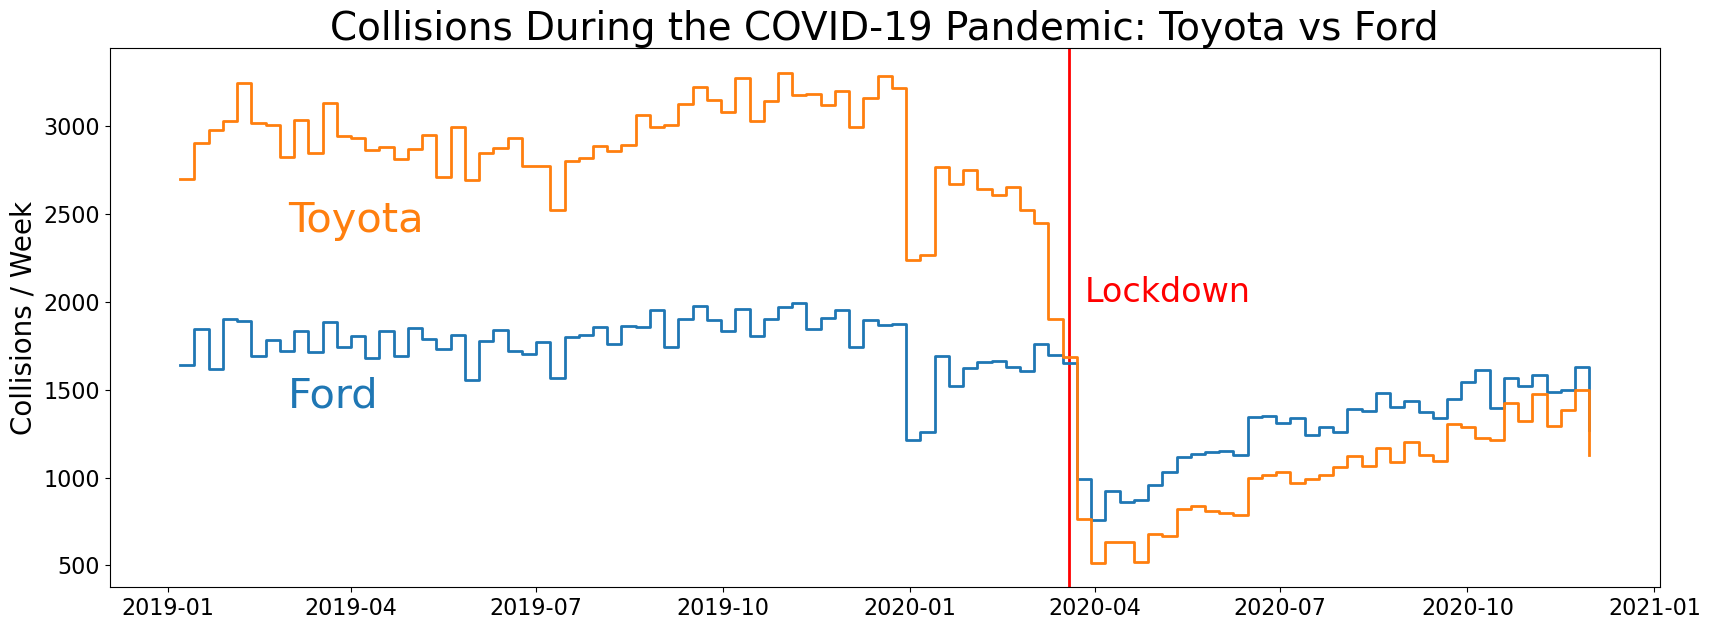

In [71]:
fig, ax = setup_plot(
    title="Collisions During the COVID-19 Pandemic: Toyota vs Ford",
    ylabel="Collisions / Week",
    xlabel="",
)

fig, ax = make_collision_plot(
    df_grouped, fig, ax, s1 = "Toyota", s2="Ford", 
    toyota_label_xy=("2019-03-01", 2400), 
    ford_label_xy=("2019-03-01", 1400), 
    stay_at_home_y=2000,
)


This trend is strange !!! One plausible explaination (resulting from some cross-research conducted) is the blue-white collar divide (they represent categories of workers in America). White collar generally have more flexible work arrangements (mainly work office) and their jobs are easier to menage from home (smart working), whereas blue collar have to travel to a job site to perform their work. 
I also found that blue collar workers are more conservative than white ones and so more likely to buy American branded cars like Ford.

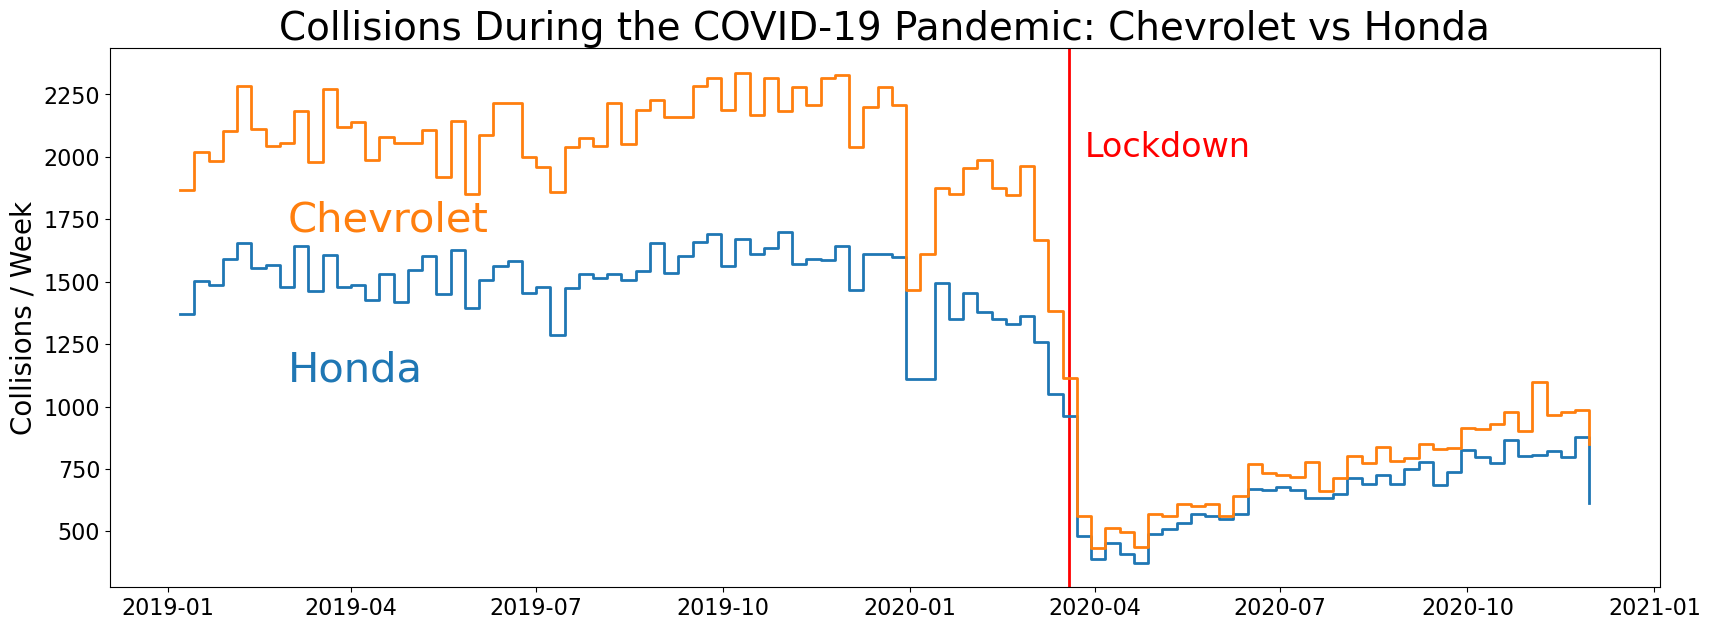

In [72]:
fig, ax = setup_plot(
    title="Collisions During the COVID-19 Pandemic: Chevrolet vs Honda",
    ylabel="Collisions / Week",
    xlabel="",
)

fig, ax = make_collision_plot(
    df_grouped1, fig, ax, s1 = "Chevrolet", s2 = "Honda", 
    toyota_label_xy=("2019-03-01", 1700), 
    ford_label_xy=("2019-03-01", 1100), 
    stay_at_home_y=2000,
)


# Closing the connection to the DB

In [ ]:
db.close()